New York City Taxi Trip Duration:
in this project we'll try to dive deep into the data and try to make a model to guess the trip duration starting from point A to point B 

In [467]:
%matplotlib inline
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

In [468]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [469]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [470]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


we can notice the presence of some outliers in our dataset, a trip duration can't be 1 second or 3526282 seconds (only if you wanted to have a world tour with your cab). also some of the longitudes and latitudes are away from NYC's location, so we need to deal with that as well.
One last step before we start is to check for missing values and our data types

In [471]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [472]:
test.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

In [473]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


no missing values! so we're clear to start.
so for data cleaning i will remove data that lies outside of 3 standard deviations from the mean 

In [474]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 1*s]
train = train[train['trip_duration'] >= m - 1*s]

In [475]:
train['trip_duration'].describe()

count   1456163.000
mean        835.175
std         650.388
min           1.000
25%         397.000
50%         661.000
75%        1072.000
max        6187.000
Name: trip_duration, dtype: float64

In [476]:
train[train['trip_duration']==1.000].count()

id                    33
vendor_id             33
pickup_datetime       33
dropoff_datetime      33
passenger_count       33
pickup_longitude      33
pickup_latitude       33
dropoff_longitude     33
dropoff_latitude      33
store_and_fwd_flag    33
trip_duration         33
dtype: int64

seems like i couldn't rid of unlogically short trips, maybe it was a human mistake or the servers had some troubles, so i'll eliminate trips <120s by myself 

In [477]:
train = train[train['trip_duration'] >= 120]

for longitude and latitude NYC borders are : 
longitude borders = (-74.03, -73.75)
latitude borders = (40.63, 40.85)

In [478]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

to understand how the date and time of the taxi trip effects the final result i will change the data type of the "pickup_datetime" and "dropoff_datetime" to datetime and then add new columns for the date of the pickup and dropoff

In [479]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

In [480]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1409679 entries, 0 to 1458643
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1409679 non-null  object        
 1   vendor_id           1409679 non-null  int64         
 2   pickup_datetime     1409679 non-null  datetime64[ns]
 3   dropoff_datetime    1409679 non-null  datetime64[ns]
 4   passenger_count     1409679 non-null  int64         
 5   pickup_longitude    1409679 non-null  float64       
 6   pickup_latitude     1409679 non-null  float64       
 7   dropoff_longitude   1409679 non-null  float64       
 8   dropoff_latitude    1409679 non-null  float64       
 9   store_and_fwd_flag  1409679 non-null  object        
 10  trip_duration       1409679 non-null  int64         
 11  pickup_date         1409679 non-null  object        
dtypes: datetime64[ns](2), float64(4), int64(3), object(3)
memory usage: 139.8+ 

now let's start analysing the data by plotting a simple histogram of the trip duration 

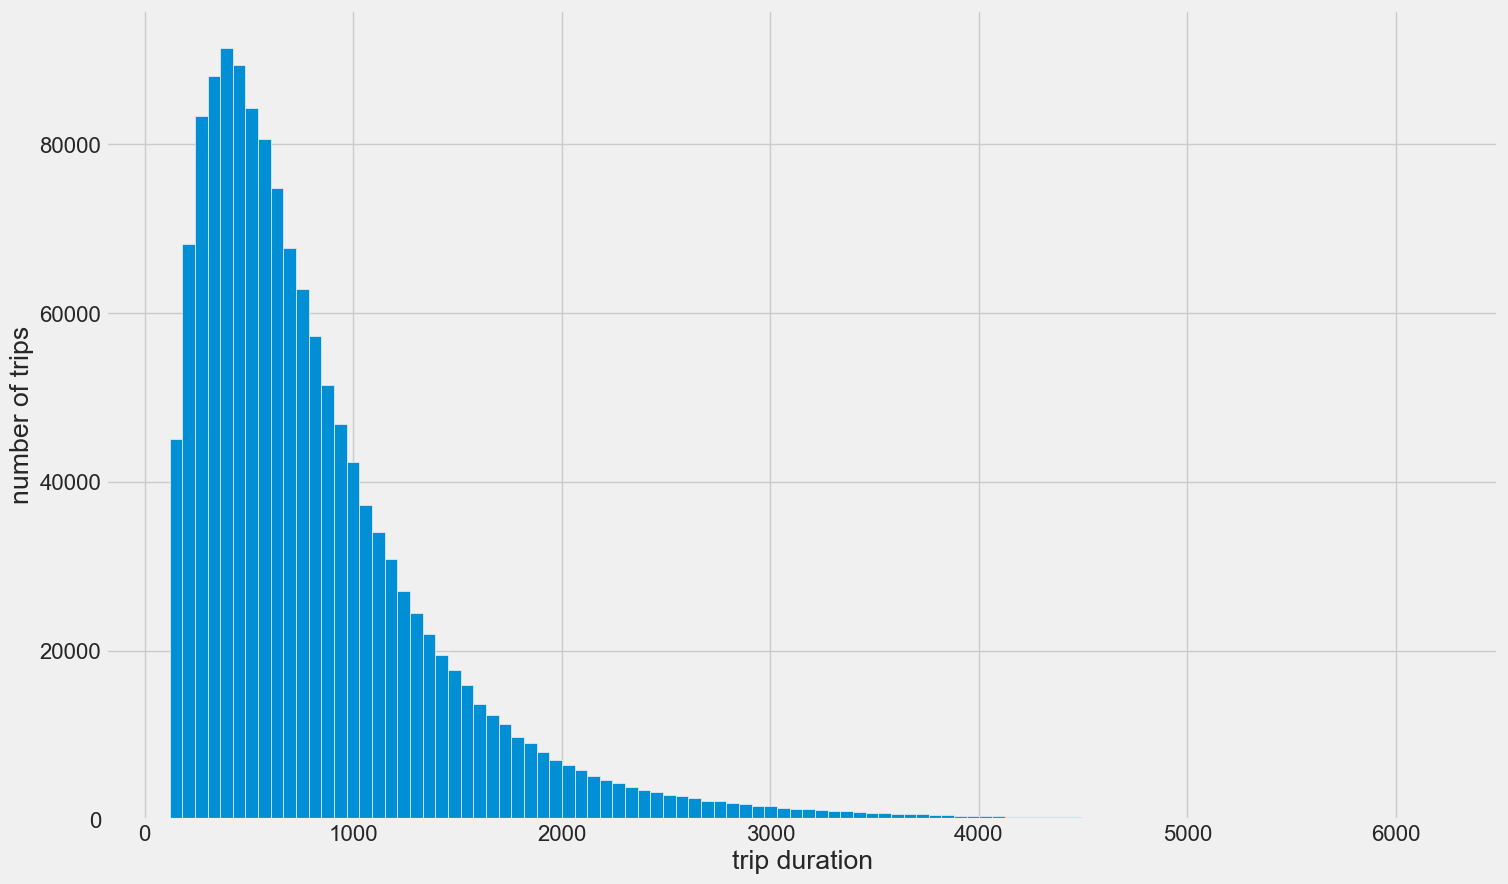

In [481]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('trip duration')
plt.ylabel('number of trips')
plt.show()

the data looks a little bit skewed so i'll use log transform to make it look like a normal distribution 

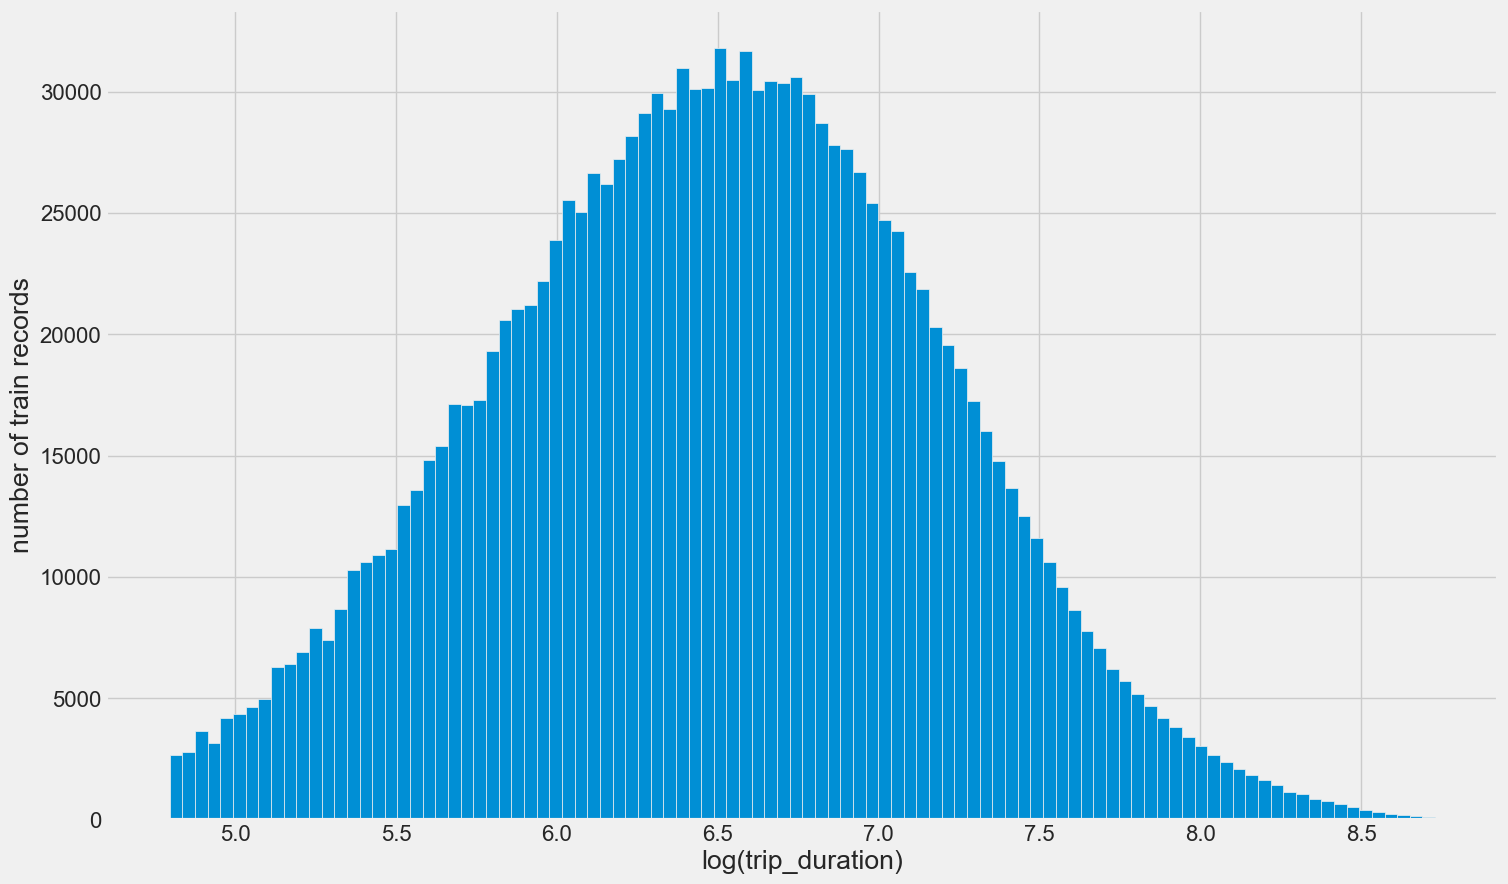

In [482]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

In [483]:
train['pickup_date'].head()

0    2016-03-14
1    2016-06-12
2    2016-01-19
3    2016-04-06
4    2016-03-26
Name: pickup_date, dtype: object

i thought that weather can be critical in estimating trip's duration, if the weather is bad then the drivers will be more careful in driving, also the traffic can be bad in these type of weathers, not to talk about closed roads and etc..
so i extracted weather data in new york starting from 01-01-2016 to 30-06-2016 (the interval of dates in my dataset) and added them to my training and testing set.

In [484]:
import json
import requests
def get_weather_data():
  url = "https://archive-api.open-meteo.com/v1/archive?latitude=40.7143&longitude=-74.006&start_date=2016-01-01&end_date=2016-06-30&daily=temperature_2m_mean,rain_sum,snowfall_sum,windspeed_10m_max&timezone=America%2FNew_York"

  response = requests.get(url)
  weather_data = json.loads(response.content)

  return weather_data

# Get the weather data for New York City from 1-1-2016 to 30-06-2016.
weather_data = get_weather_data()

In [485]:
weather = pd.DataFrame.from_dict(weather_data)

In [486]:
weather.head()

,latitude,longitude,generationtime_ms,utc_offset_seconds,timezone,timezone_abbreviation,elevation,daily_units,daily
time,40.700,-74.000,0.469,-14400,America/New_York,EDT,51.000,iso8601,"[2016-01-01, 2016-01-02, 2016-01-03, 2016-01-0..."
temperature_2m_mean,40.700,-74.000,0.469,-14400,America/New_York,EDT,51.000,°C,"[3.1, 0.9, 1.8, -2.6, -6.1, -2.8, -0.2, 2.1, 5..."
rain_sum,40.700,-74.000,0.469,-14400,America/New_York,EDT,51.000,mm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, ..."
snowfall_sum,40.700,-74.000,0.469,-14400,America/New_York,EDT,51.000,cm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
windspeed_10m_max,40.700,-74.000,0.469,-14400,America/New_York,EDT,51.000,km/h,"[21.1, 15.5, 19.1, 26.3, 25.7, 10.2, 8.5, 12.7..."


In [487]:
data1 = {'pickup_date':weather["daily"][0],
         'temperature':weather["daily"][1],
         'rain_sum':weather["daily"][2],
         'snowfall_sum':weather["daily"][3],
         }
  
# Create DataFrame
df = pd.DataFrame(data1)
df.head()

C:\Users\HP Omen\AppData\Local\Temp\ipykernel_23420\402015857.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data1 = {'pickup_date':weather["daily"][0],
C:\Users\HP Omen\AppData\Local\Temp\ipykernel_23420\402015857.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'temperature':weather["daily"][1],
C:\Users\HP Omen\AppData\Local\Temp\ipykernel_23420\402015857.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'rain_sum':weat

,pickup_date,temperature,rain_sum,snowfall_sum
0,2016-01-01,3.100,0.000,0.000
1,2016-01-02,0.900,0.000,0.000
2,2016-01-03,1.800,0.000,0.000
3,2016-01-04,-2.600,0.000,0.000
4,2016-01-05,-6.100,0.000,0.000


In [488]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pickup_date   182 non-null    object 
 1   temperature   182 non-null    float64
 2   rain_sum      182 non-null    float64
 3   snowfall_sum  182 non-null    float64
dtypes: float64(3), object(1)
memory usage: 5.8+ KB


In [489]:
df['pickup_date'] = pd.to_datetime(df.pickup_date)
df['pickup_date'] = df['pickup_date'].dt.date

In [490]:
train = pd.merge(train, df, on='pickup_date')
test = pd.merge(test, df, on='pickup_date')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,log_trip_duration,temperature,rain_sum,snowfall_sum
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,2016-03-14,6.122,6.500,4.600,0.000
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975,40.759,-73.953,40.765,N,1346,2016-03-14,7.206,6.500,4.600,0.000
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994,40.745,-73.999,40.723,N,695,2016-03-14,6.545,6.500,4.600,0.000
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944,40.714,-73.911,40.709,N,755,2016-03-14,6.628,6.500,4.600,0.000
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.953,40.766,-73.979,40.762,N,1050,2016-03-14,6.957,6.500,4.600,0.000


i had to normalize the values of everything so the chart will be readable.

In [491]:
norm_trip_duration = train.groupby('pickup_date')[['trip_duration']].mean()

In [492]:
mini, maxi = min(norm_trip_duration['trip_duration']), max(norm_trip_duration['trip_duration'])
for i, val in enumerate(norm_trip_duration['trip_duration']):
    norm_trip_duration['trip_duration'][i] = 2*(val-mini) / (maxi-mini)

C:\Users\HP Omen\AppData\Local\Temp\ipykernel_23420\1768585581.py:3: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  norm_trip_duration['trip_duration'][i] = 2*(val-mini) / (maxi-mini)


In [493]:
norm_temperature = df.groupby('pickup_date')['temperature'].apply(float)

C:\Users\HP Omen\AppData\Local\Temp\ipykernel_23420\3594428050.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  norm_temperature = df.groupby('pickup_date')['temperature'].apply(float)


In [494]:
mini, maxi = min(norm_temperature), max(norm_temperature)
for i, val in enumerate(norm_temperature):
    norm_temperature[i] = 2*(val-mini) / (maxi-mini)

C:\Users\HP Omen\AppData\Local\Temp\ipykernel_23420\2189076592.py:3: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  norm_temperature[i] = 2*(val-mini) / (maxi-mini)


now let me see how the mean of trip durations is effected by the temperature, the rain count and the snowfall count

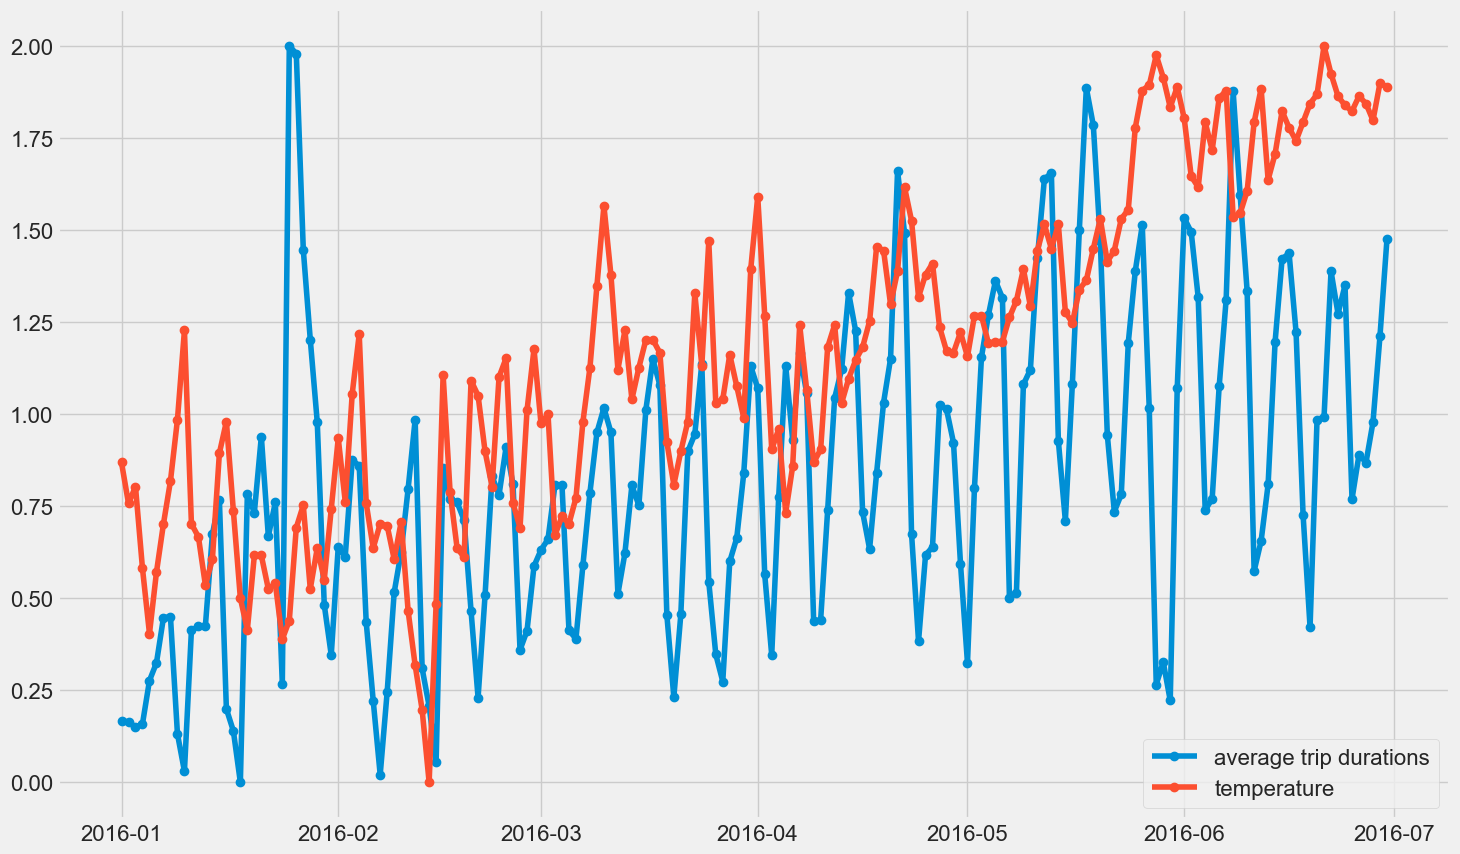

In [495]:
plt.plot(norm_trip_duration, 'o-', label='average trip durations')
plt.plot(norm_temperature, 'o-', label='temperature')
plt.legend(loc=0)
plt.show()

In [496]:
norm_rain = df.groupby('pickup_date')['rain_sum'].apply(float)

C:\Users\HP Omen\AppData\Local\Temp\ipykernel_23420\386003303.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  norm_rain = df.groupby('pickup_date')['rain_sum'].apply(float)


In [497]:
mini, maxi = min(norm_rain), max(norm_rain)
for i, val in enumerate(norm_rain):
    norm_rain[i] = 2*(val-mini) / (maxi-mini)

C:\Users\HP Omen\AppData\Local\Temp\ipykernel_23420\701718519.py:3: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  norm_rain[i] = 2*(val-mini) / (maxi-mini)


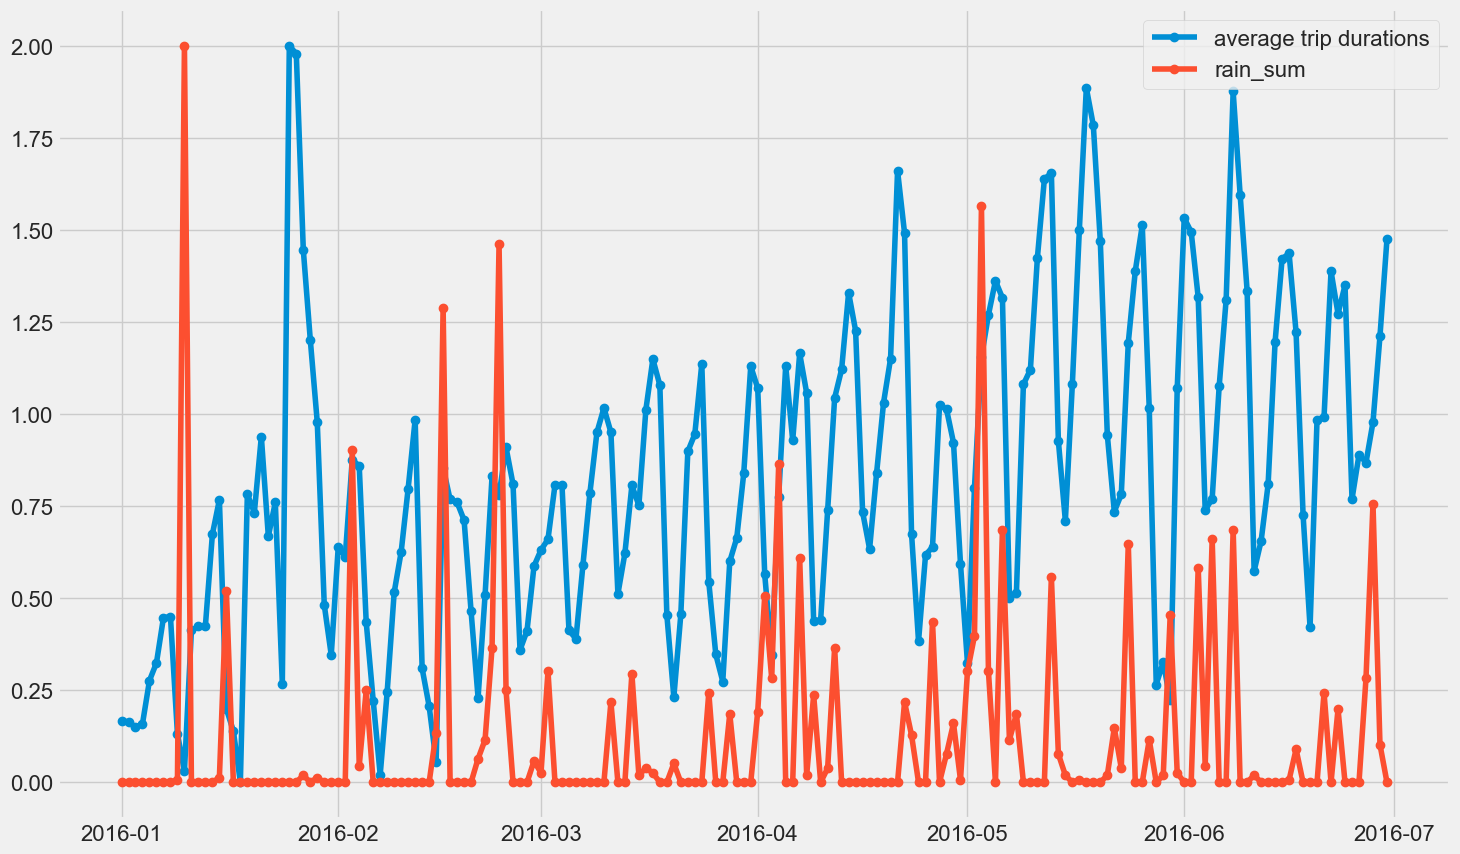

In [498]:
plt.plot(norm_trip_duration, 'o-', label='average trip durations')
plt.plot(norm_rain, 'o-', label='rain_sum')
plt.legend(loc=0)
plt.show()

In [499]:
norm_snowfall = df.groupby('pickup_date')['snowfall_sum'].apply(float)

C:\Users\HP Omen\AppData\Local\Temp\ipykernel_23420\869671468.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  norm_snowfall = df.groupby('pickup_date')['snowfall_sum'].apply(float)


In [500]:
mini, maxi = min(norm_snowfall), max(norm_snowfall)
for i, val in enumerate(norm_snowfall):
    norm_snowfall[i] = 2*(val-mini) / (maxi-mini)

C:\Users\HP Omen\AppData\Local\Temp\ipykernel_23420\144992657.py:3: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  norm_snowfall[i] = 2*(val-mini) / (maxi-mini)


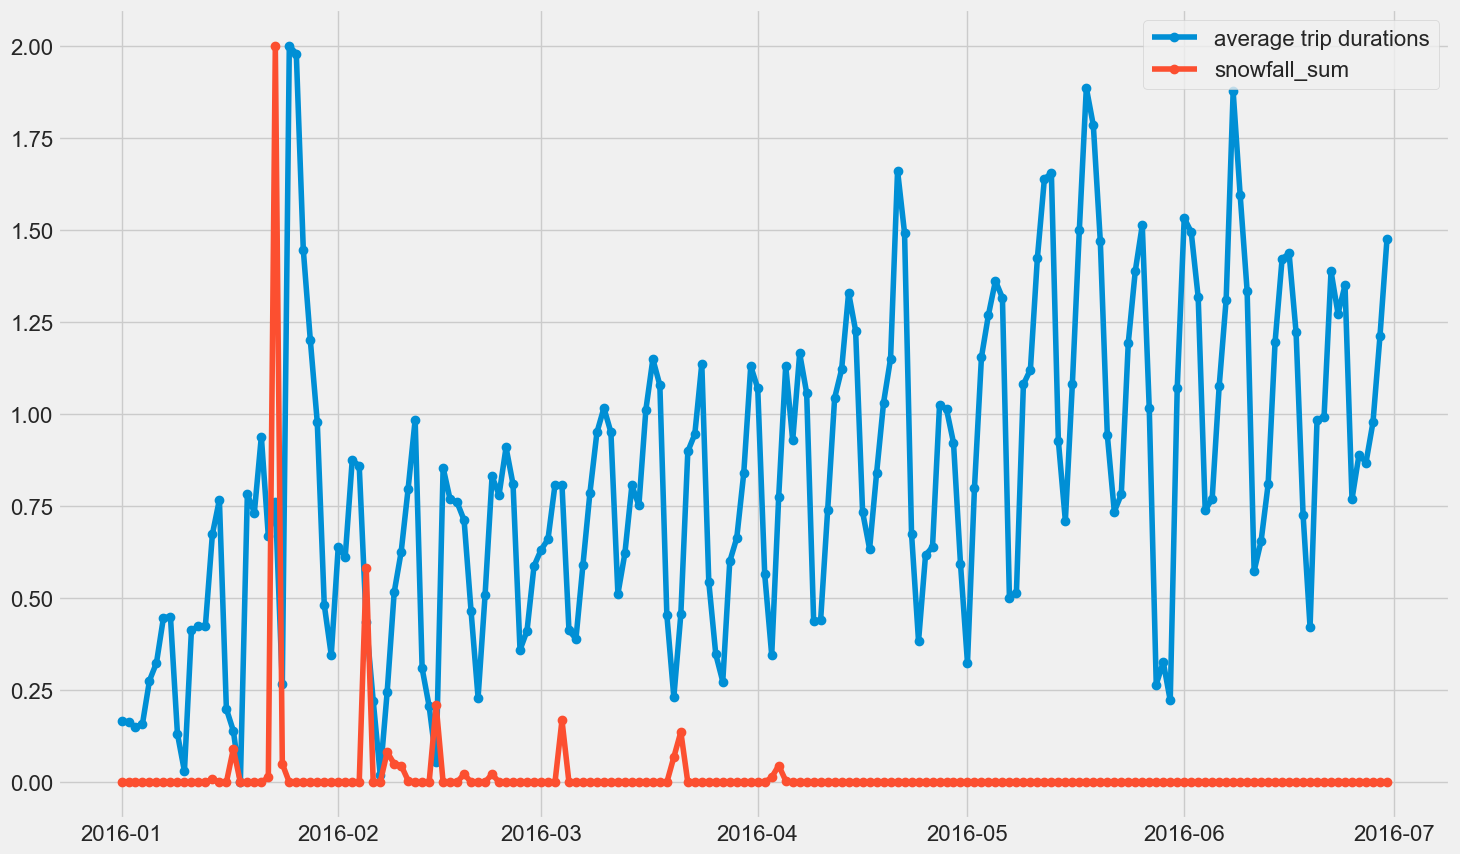

In [501]:
plt.plot(norm_trip_duration, 'o-', label='average trip durations')
plt.plot(norm_snowfall, 'o-', label='snowfall_sum')
plt.legend(loc=0)
plt.show()

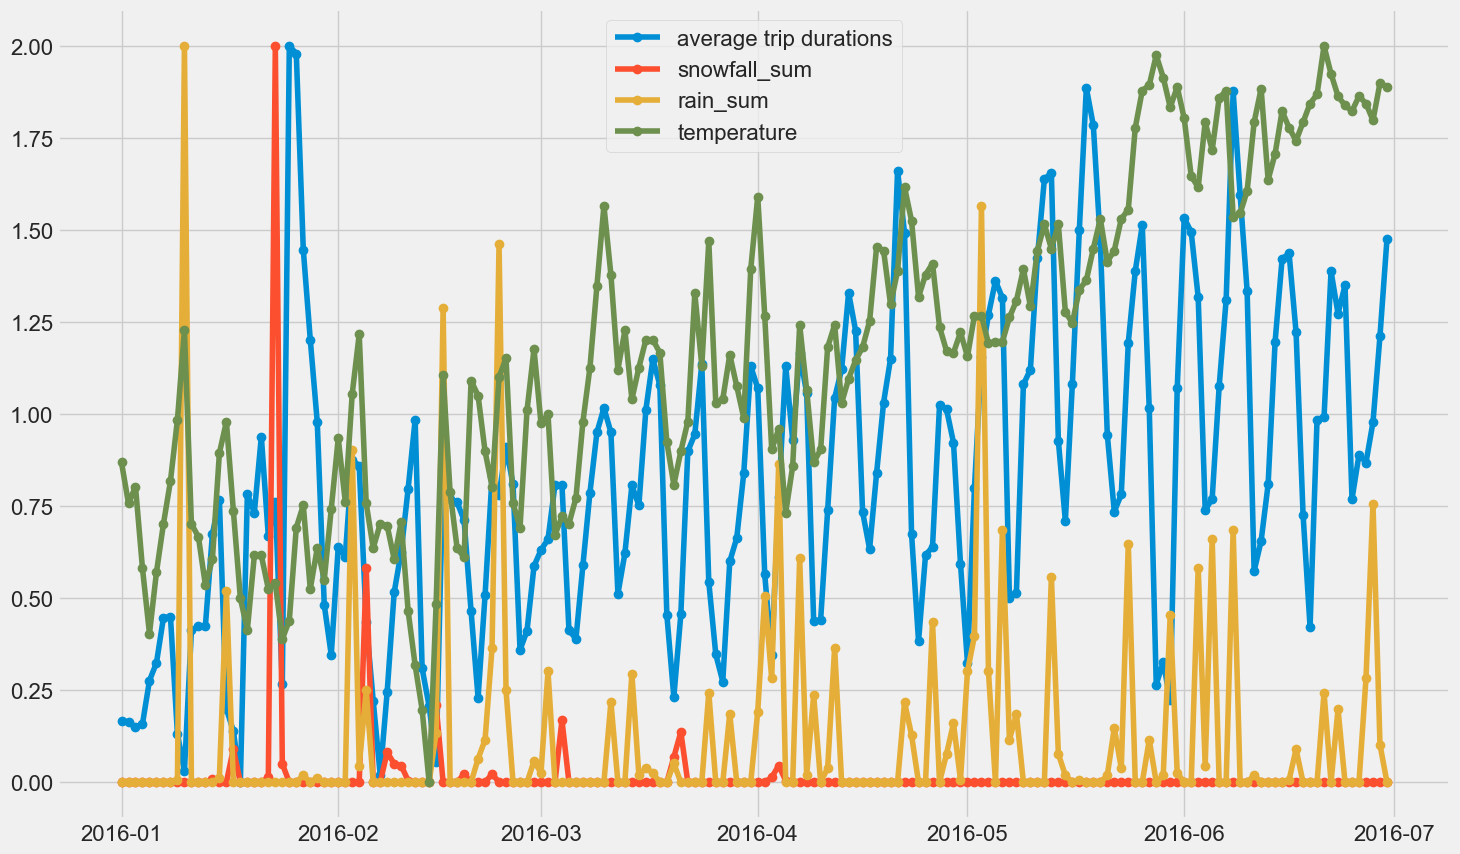

In [502]:
plt.plot(norm_trip_duration, 'o-', label='average trip durations')
plt.plot(norm_snowfall, 'o-', label='snowfall_sum')
plt.plot(norm_rain, 'o-', label='rain_sum')
plt.plot(norm_temperature, 'o-', label='temperature')
plt.legend(loc=0)
plt.show()

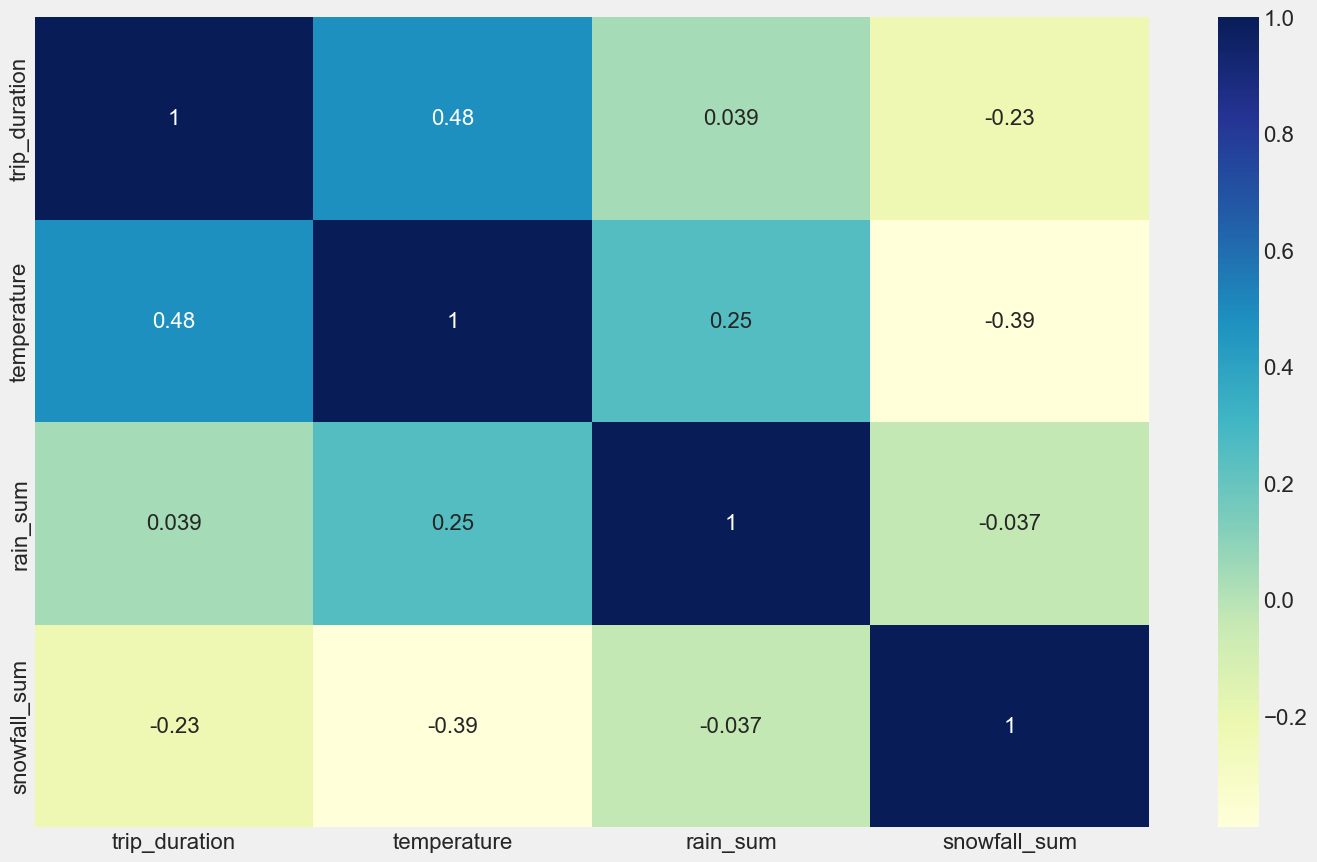

In [503]:
q = pd.concat([norm_trip_duration, norm_temperature, norm_rain, norm_snowfall], axis=1)
dataplot = sns.heatmap(q.corr(method = 'spearman'), cmap="YlGnBu", annot=True) 
plt.show()

we can notice a high correlation between the duration of trips and temperature, and a small correlation between trips duration and snowfall sum, but surprisingly nothing connected with rain. maybe all of that can be explained by the traffic, if there is snowfall then the traffic will be low generally and etc..
i used the spearman method which is less sensitive to skewed data and i see that the relationship between temperature, rain and snowfall is not linear.

let us now scatter the points of pickup locations to guess the most busy places, we'll use the available coordinates to make that :

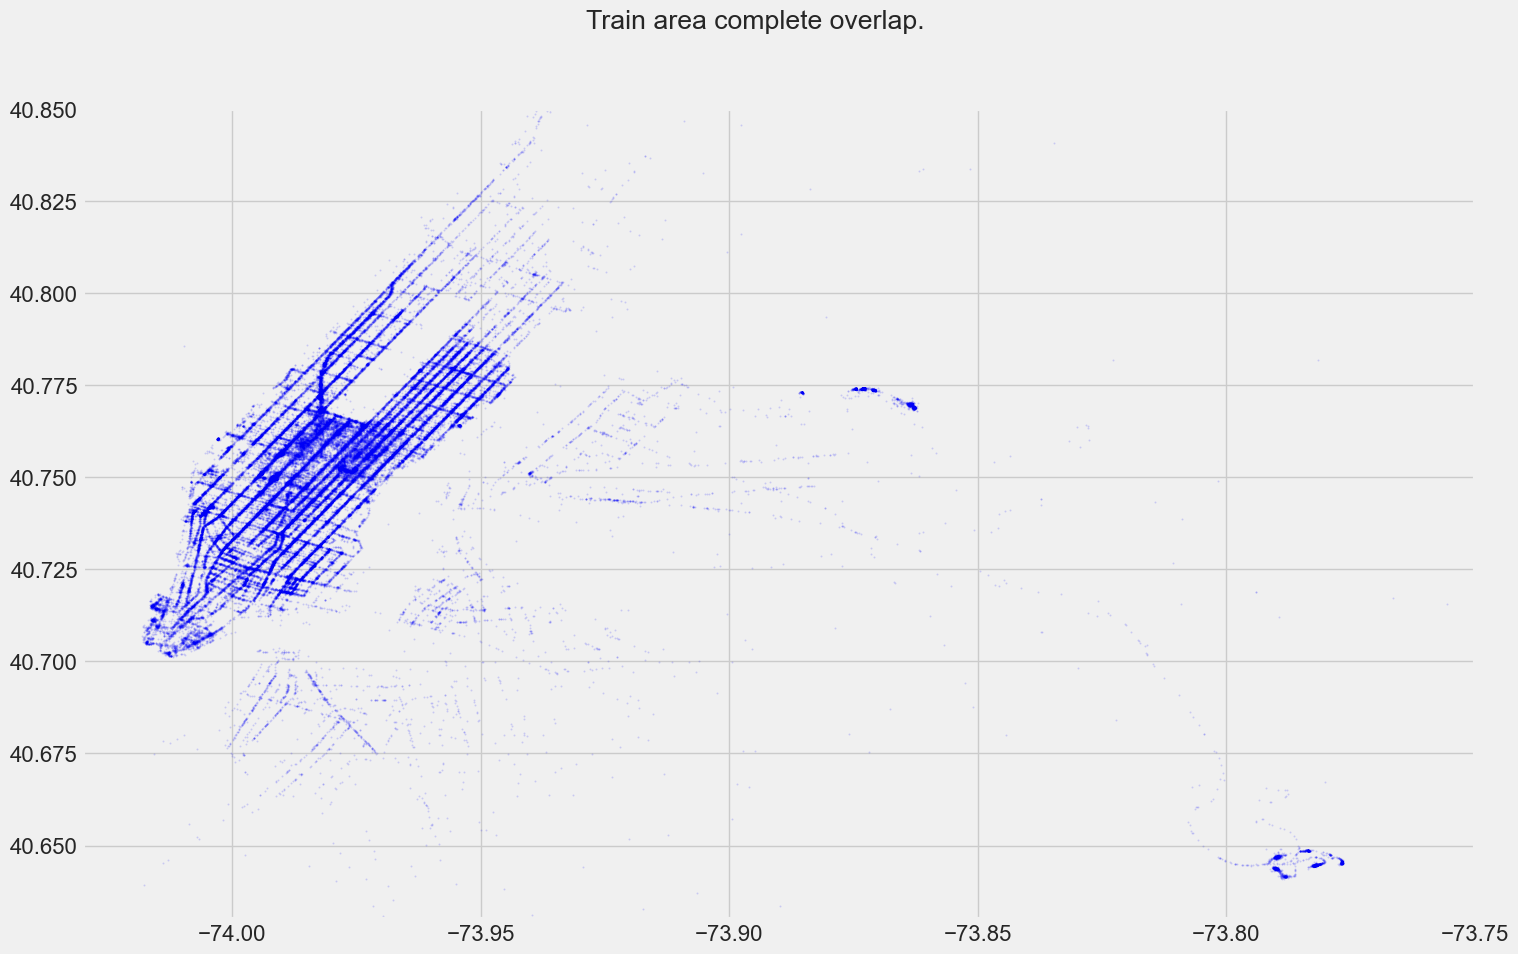

In [504]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
plt.suptitle('Train area complete overlap.')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

i wanted to add distance between pickup and dropoff points, to calculate distance between two coordinates i found out that we can use the manhattan distance using haversine distance (which is the great-circle distance between two points on a sphere given their longitudes and latitudes) and we can also get the direction of the distance traveled.

In [505]:
def haversine(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h
def manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

def bearing(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

now i'll add them to the train and test set

In [506]:
train.loc[:, 'distance_haversine'] = haversine(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_haversine'] = haversine(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)    
    
train.loc[:, 'distance_dummy_manhattan'] =  manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] =  manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'direction'] = bearing(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

In [507]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,log_trip_duration,temperature,rain_sum,snowfall_sum,distance_haversine,distance_dummy_manhattan,direction
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,2016-03-14,6.122,6.500,4.600,0.000,1.499,1.735,99.970
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975,40.759,-73.953,40.765,N,1346,2016-03-14,7.206,6.500,4.600,0.000,1.972,2.544,69.181
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994,40.745,-73.999,40.723,N,695,2016-03-14,6.545,6.500,4.600,0.000,2.517,2.868,-171.317
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944,40.714,-73.911,40.709,N,755,2016-03-14,6.628,6.500,4.600,0.000,2.905,3.407,101.017
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.953,40.766,-73.979,40.762,N,1050,2016-03-14,6.957,6.500,4.600,0.000,2.227,2.674,-103.116


now i will extract months, days and hours to do some analysis on them

In [508]:
train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month

In [509]:
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day

In [510]:
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour

In [511]:
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek

In [512]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1409679 entries, 0 to 1409678
Data columns (total 23 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   id                        1409679 non-null  object        
 1   vendor_id                 1409679 non-null  int64         
 2   pickup_datetime           1409679 non-null  datetime64[ns]
 3   dropoff_datetime          1409679 non-null  datetime64[ns]
 4   passenger_count           1409679 non-null  int64         
 5   pickup_longitude          1409679 non-null  float64       
 6   pickup_latitude           1409679 non-null  float64       
 7   dropoff_longitude         1409679 non-null  float64       
 8   dropoff_latitude          1409679 non-null  float64       
 9   store_and_fwd_flag        1409679 non-null  object        
 10  trip_duration             1409679 non-null  int64         
 11  pickup_date               1409679 non-null  object

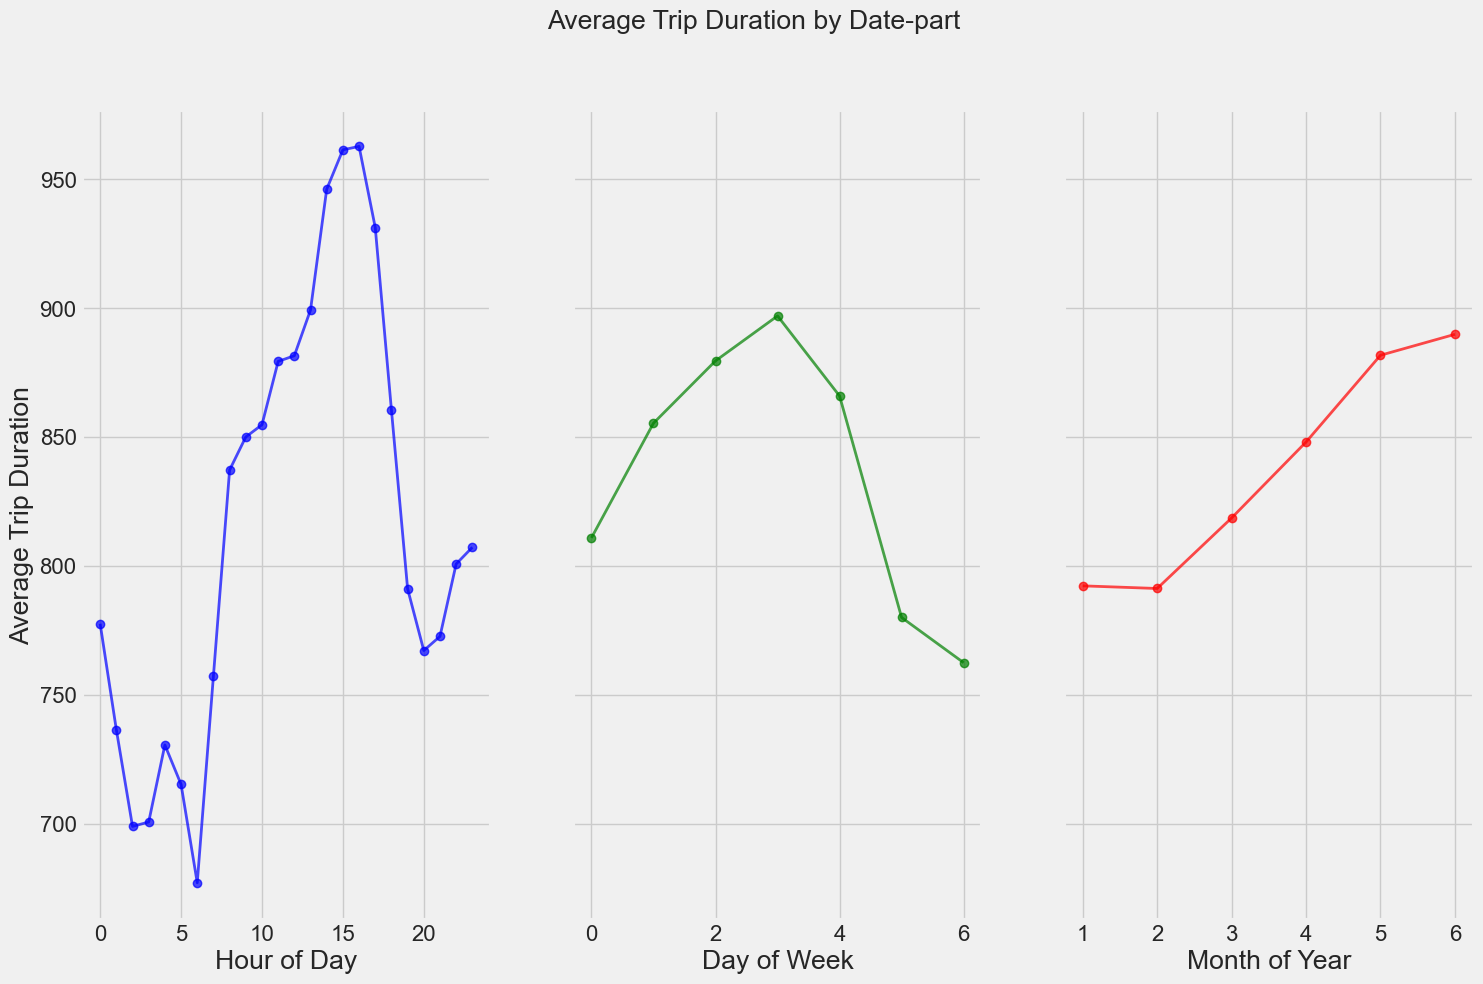

In [513]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('Hour')['trip_duration'].mean(), 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('dayofweek')['trip_duration'].mean(), 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('Month')['trip_duration'].mean(), 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Trip Duration')
fig.suptitle('Average Trip Duration by Date-part')
plt.show()

we can notice that trips take much longer on working times, and we can also notice an important rise in summer times. to make sure that it's traffic i'll do the same analysis on the average trips distance.

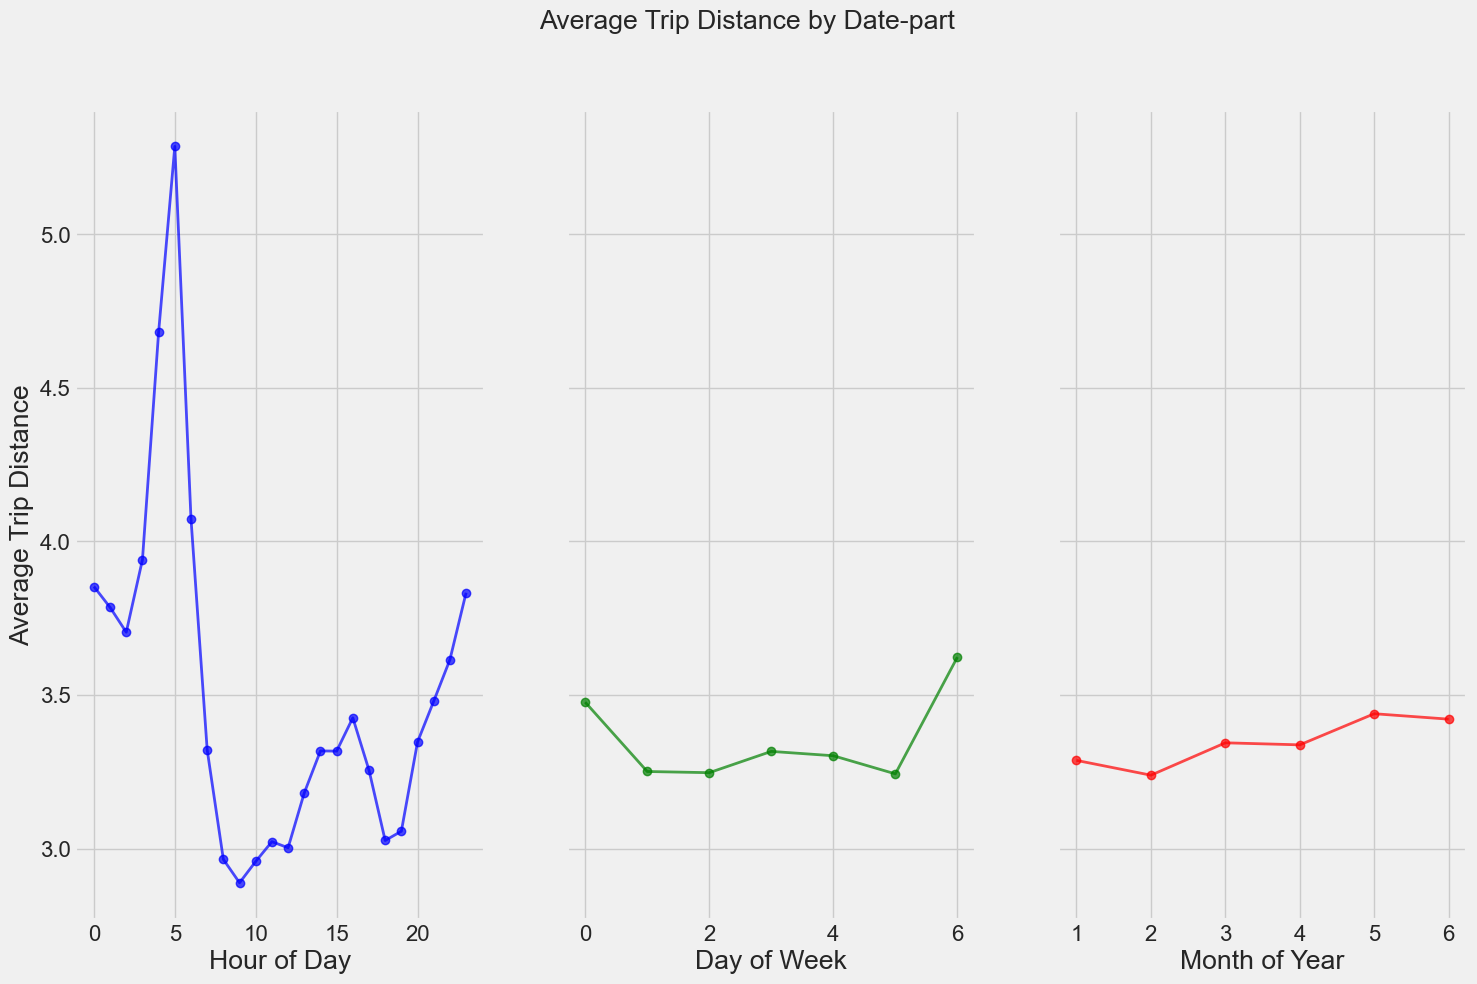

In [514]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('Hour')['distance_haversine'].mean(), 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('dayofweek')['distance_haversine'].mean(), 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('Month')['distance_haversine'].mean(), 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Trip Distance')
fig.suptitle('Average Trip Distance by Date-part')
plt.show()

from here we can notice that on work time taxi trips distance decreases but takes much longer times, so we can understand the behaviour of traffic here.

the next step is to use KMeans to make clusters for the pickup and drop-off points, that will help the model to predict the result easier and much more faster.

In [515]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values, train[['dropoff_latitude', 'dropoff_longitude']].values))
sample_ind = np.random.permutation(len(coords))
kmeans = MiniBatchKMeans(n_clusters=500, batch_size=10000).fit(coords[sample_ind])
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

C:\Users\HP Omen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\HP Omen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(
C:\Users\HP Omen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(
C:\Users\HP Omen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(
C:\Users\HP Omen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458:

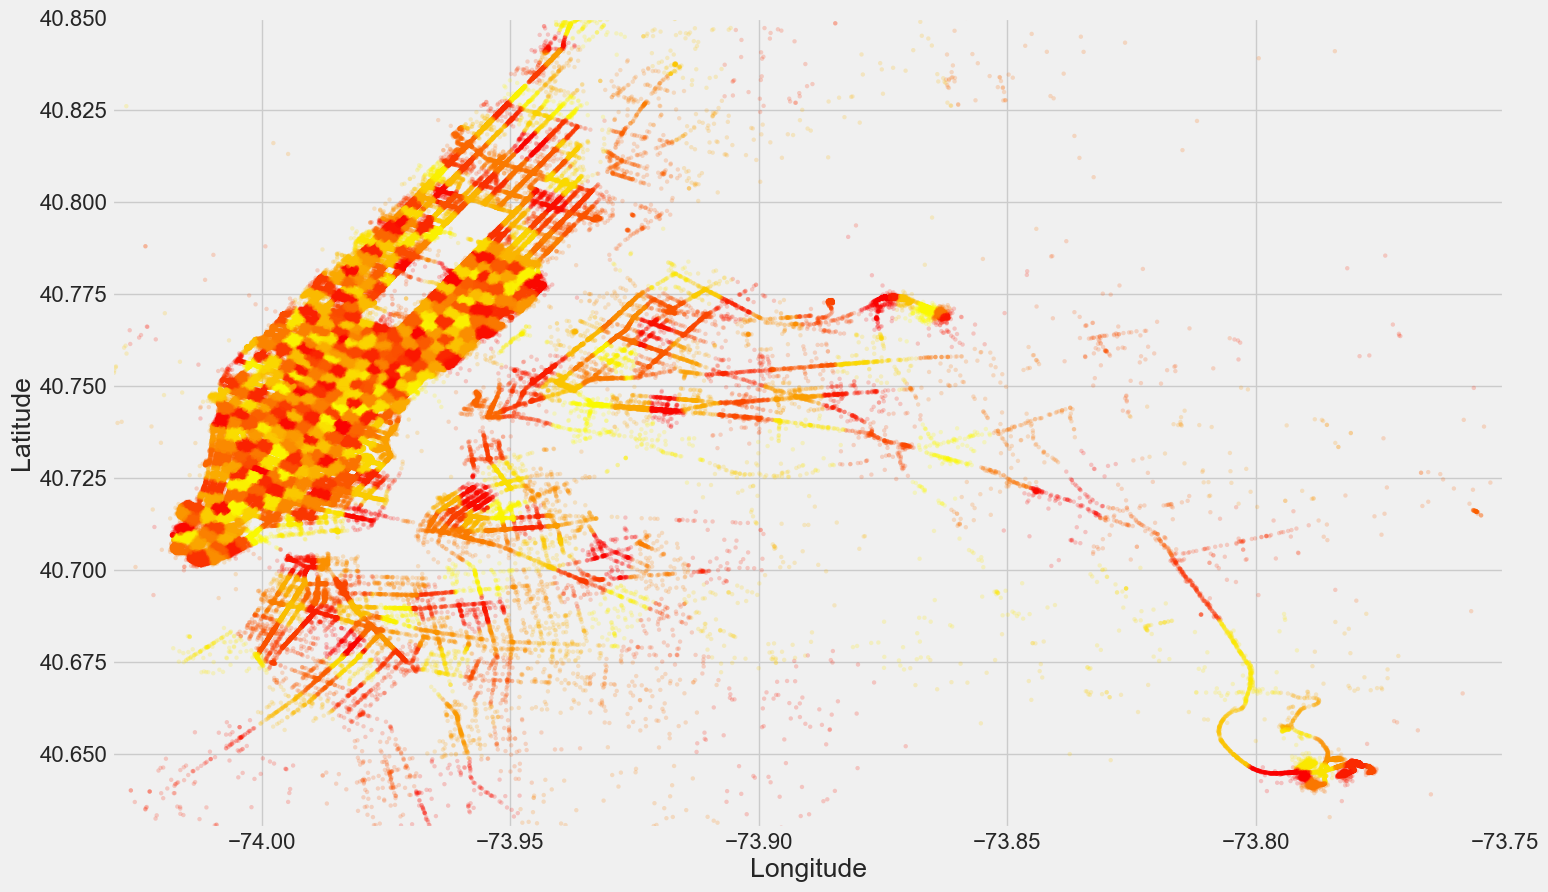

In [516]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values, train.pickup_latitude.values, s=10, lw=0,
           c=train.pickup_cluster.values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

now it's the time for encoding the data and get rid of the columns that we don't need anymore

In [517]:
train.shape

(1409679, 25)

In [518]:
test.shape

(625134, 22)

In [519]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'log_trip_duration', 'temperature',
       'rain_sum', 'snowfall_sum', 'distance_haversine',
       'distance_dummy_manhattan', 'direction', 'Month', 'DayofMonth', 'Hour',
       'dayofweek', 'pickup_cluster', 'dropoff_cluster'],
      dtype='object')

In [520]:
test.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'pickup_date', 'temperature',
       'rain_sum', 'snowfall_sum', 'distance_haversine',
       'distance_dummy_manhattan', 'direction', 'Month', 'DayofMonth', 'Hour',
       'dayofweek', 'pickup_cluster', 'dropoff_cluster'],
      dtype='object')

In [521]:
train = train.drop(['id','dropoff_datetime','trip_duration'], axis=1)
test = test.drop(['id'], axis=1)

In [522]:
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')

In [523]:
train = train.drop(['store_and_fwd_flag'], axis=1)
test = test.drop(['store_and_fwd_flag'], axis=1)
train = pd.concat([train,store_and_fwd_flag_train], axis=1)
test = pd.concat([test,store_and_fwd_flag_test], axis=1)

In [524]:
train = train.drop(['pickup_datetime','pickup_date'],axis = 1)
test = test.drop(['pickup_datetime','pickup_date'],axis = 1)

In [525]:
train_final = train
test_final = test

In [526]:
train_final.shape,test_final.shape

((1409679, 21), (625134, 20))

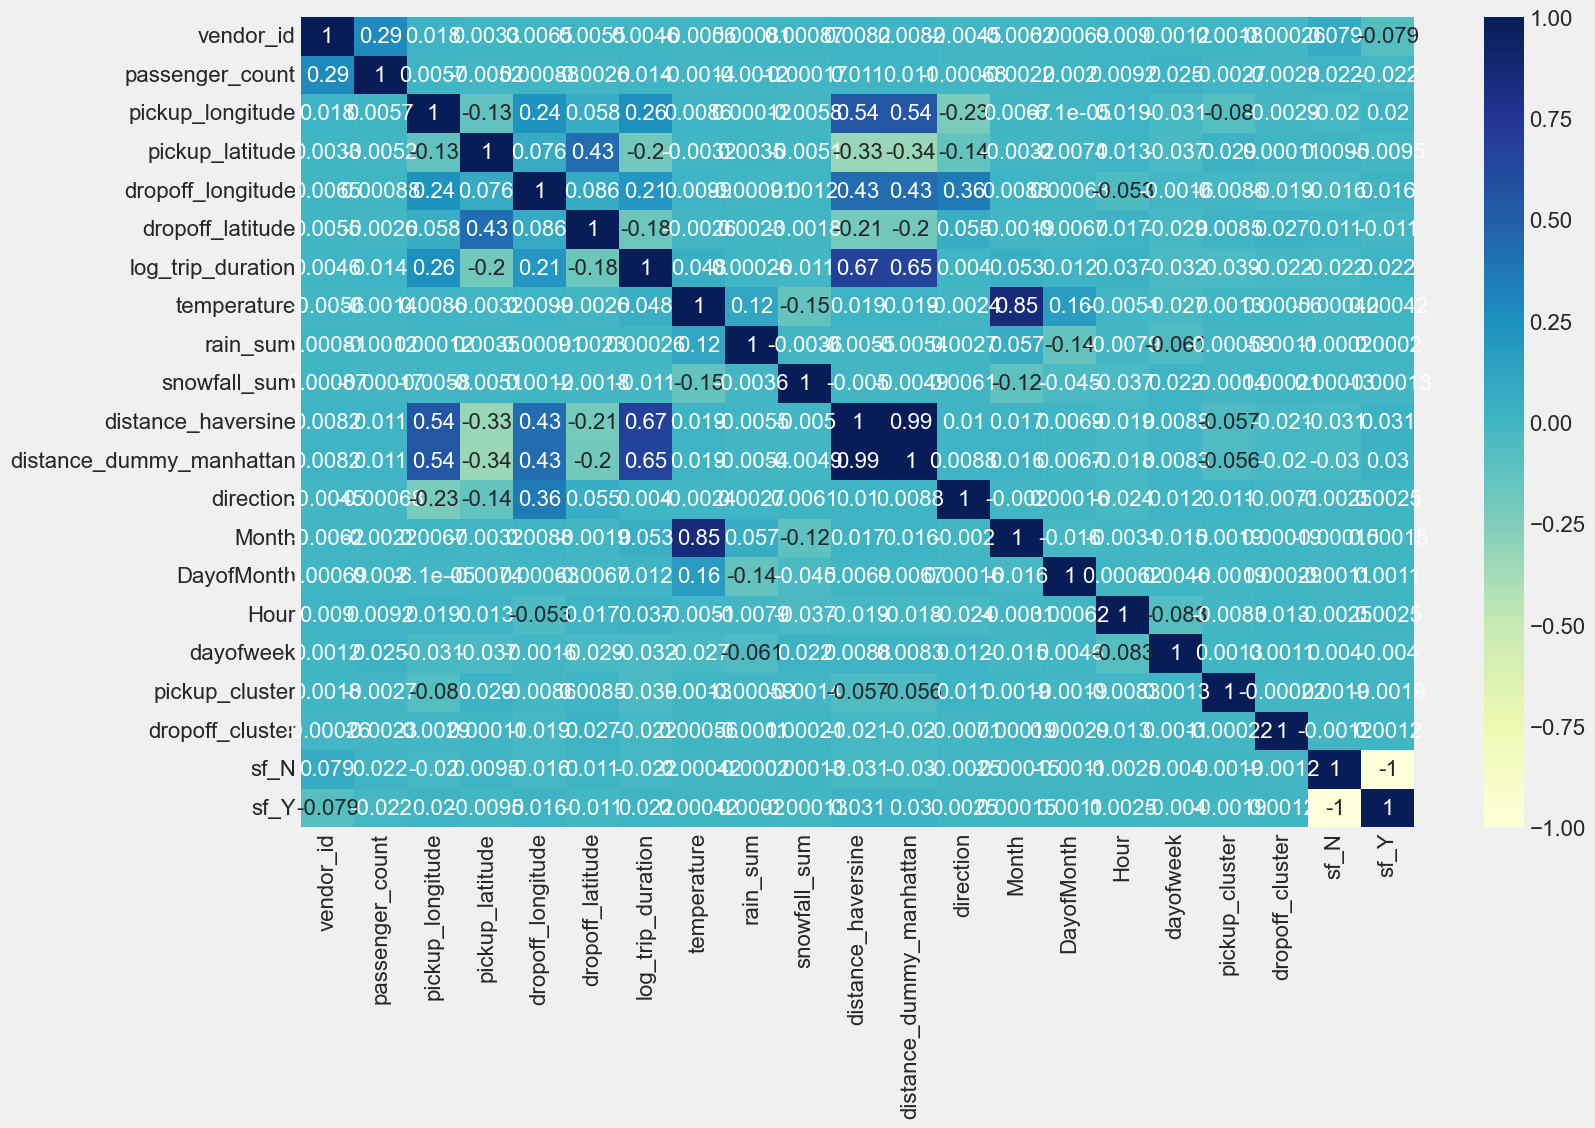

In [527]:
dataplot = sns.heatmap(train_final.corr(), cmap="YlGnBu", annot=True) 
plt.show()

the training set should have one more column than the test set, since it contains our target variable (which the test set doesn't because it was meant for a kaggle competition).


now it's time to split the training set to a training set and a cross-validation set so we can test the bias and variance rate on it to guarantee the integrity of our model.

In [529]:
x = train_final.drop('log_trip_duration', axis=1)
y = train_final['log_trip_duration']
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2,random_state=40)

for training i used the xgbRegressor model for training and optuna for hyperparameter optimization 

In [530]:
import optuna
from sklearn.metrics import mean_squared_error

In [531]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 0.3), 
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 0.3),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300)
    }

    model = XGBRegressor(**params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    cv_score = mean_squared_error(y_true=y_test, y_pred=y_pred)
    return cv_score


In [532]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_trial.params
model = XGBRegressor(**best_params,nthreads=-1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cv_score = mean_squared_error(y_true=y_test, y_pred=y_pred)

[I 2023-10-26 16:49:50,172] A new study created in memory with name: no-name-906b65b1-5dea-4723-91d1-b67dae88f86d
C:\Users\HP Omen\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\HP Omen\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\HP Omen\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\HP Omen\AppData\Local\Programs\Python\Python312\Lib\sit

In [533]:
print('CV score:', cv_score)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE score:", rmse)

CV score: 0.0802178856682229
RMSE score: 0.28322762165477944


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

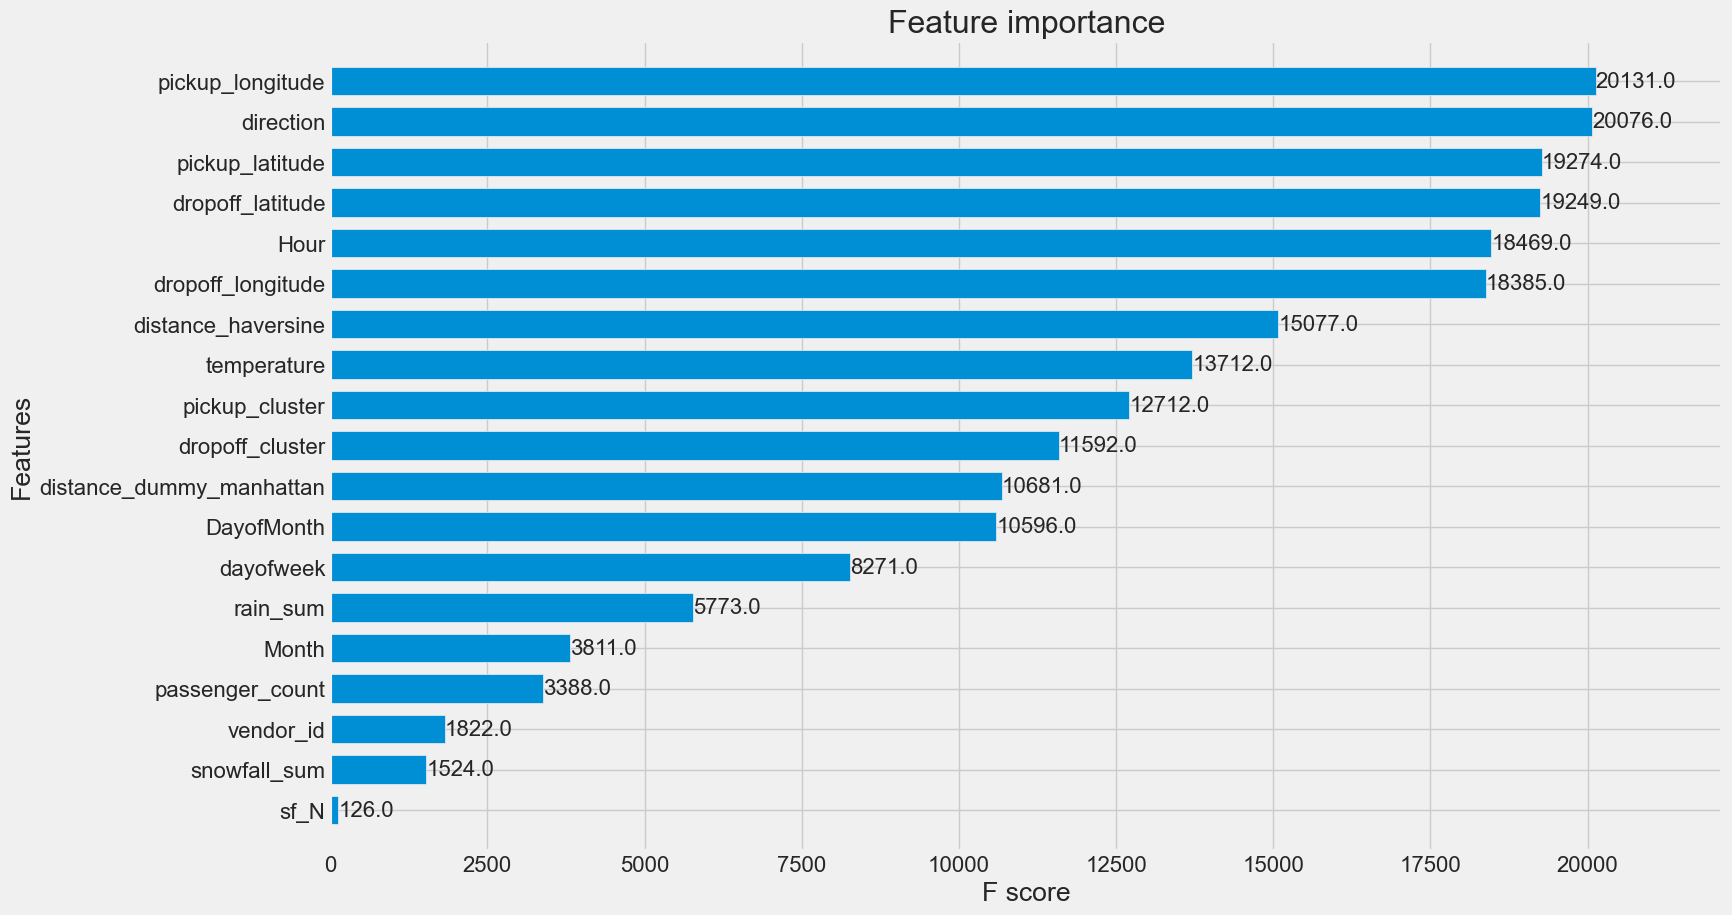

In [534]:
import xgboost as xgb
from xgboost import plot_importance
xgb.plot_importance(model, max_num_features=28, height=0.7)